# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Tấn Thắng
- MSSV: 23127259
- Lớp: 23CLC02

## Import các thư viện liên quan

In [51]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Helper functions

In [52]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    # YOUR CODE HERE
    img = Image.open(img_path)
    img_2d = np.array(img)
    return img_2d


def show_img(img_2d, title=None):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    # YOUR CODE HERE
    plt.imshow(img_2d)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    img = Image.fromarray(img_2d)
    img.save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    # YOUR CODE HERE
    height, width, num_channels = img_2d.shape #Lấy kích thước cơ bản của ảnh
    img_1d = img_2d.reshape(height * width, num_channels) #mỗi hàng tương ứng với một pixel, mỗi cột là một kênh màu (R, G, B)
    if img_2d.ndim == 2:
      img_2d = img_2d[..., None]
    return img_1d


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''

    # YOUR CODE HERE
    tol          = 1e-4
    n_init       = 5                 # chạy lại 5 lần, lấy SSE thấp nhất
    rng_master   = np.random.default_rng()  # sinh RNG gốc
    X            = img_1d.astype(np.float32)
    N, C         = X.shape
    best_sse     = np.inf
    best_centers = None
    best_labels  = None
    for _ in range(n_init):
        rng = np.random.default_rng(rng_master.integers(0, 2**32))
        # khởi tạo centroid
        if init_centroids == 'random':
            centers = rng.uniform(0, 255, (k_clusters, C)).astype(np.float32)
        elif init_centroids == 'in_pixels':
            centers = X[rng.choice(N, k_clusters, replace=False)].copy()
        else:
            raise ValueError("init_centroids must be 'random' or 'in_pixels'")
        # vòng lặp Lloyd
        for _ in range(max_iter):
            # gán cụm (khoảng cách Euclid bình phương, vector-hoá)
            dists  = (np.sum(X**2, axis=1, keepdims=True) +
                      np.sum(centers**2, axis=1) -
                      2 * X @ centers.T)
            labels = np.argmin(dists, axis=1)
            # cập nhật centroid
            new_centers = np.zeros_like(centers)
            for k in range(k_clusters):
                pts = X[labels == k]
                new_centers[k] = pts.mean(axis=0) if pts.size else X[rng.integers(0, N)]
            # kiểm tra hội tụ
            if np.linalg.norm(new_centers - centers) < tol:
                centers = new_centers
                break
            centers = new_centers
        # chọn lần tốt nhất
        sse = np.sum((X - centers[labels])**2)
        if sse < best_sse:
            best_sse, best_centers, best_labels = sse, centers, labels
    # trả về centroid dạng float32; ép uint8 khi tái dựng ảnh
    return best_centers, best_labels



def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''

    # YOUR CODE HERE
    # labels có kích thước (H·W,), centroids (K, C)
    img_flat = centroids[labels]                # (H·W, C)
    return img_flat.reshape(img_2d_shape).astype(np.uint8)


# Your additional functions here
#Hàm này tổng hợp các thao tác đã được viết trong các hàm xử lý trên
def compress_image(path, k, max_iter=50, init='in_pixels'):
    img = read_img(path)
    vec = convert_img_to_1d(img)
    cents, labels = kmeans(vec, k, max_iter, init)
    comp = np.rint(cents)[labels].reshape(img.shape).astype(np.uint8)
    return img, comp, cents, labels


## Your tests

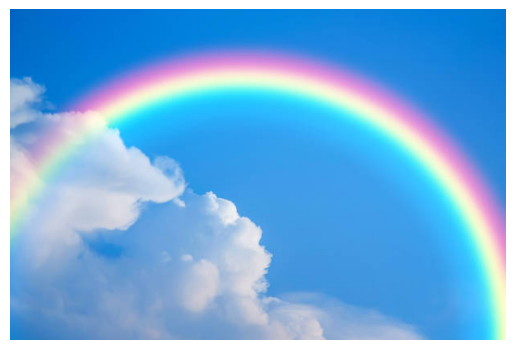

In [53]:
# YOUR CODE HERE
#Đọc ảnh
img = read_img("/content/sample_data/dummy.jpg")
show_img(img)

In [54]:
#Chuyển đổi ảnh sang dạng 1d
img_1d = convert_img_to_1d(img)
print("Shape ảnh 1D:", img_1d.shape)

Shape ảnh 1D: (249696, 3)


In [55]:
#Sử dụng thuật toán K-means trường hợp k = 3
centroids, labels = kmeans(img_1d, k_clusters=3, max_iter=50, init_centroids='in_pixels')
print("Số cụm màu:", centroids.shape[0])

Số cụm màu: 3


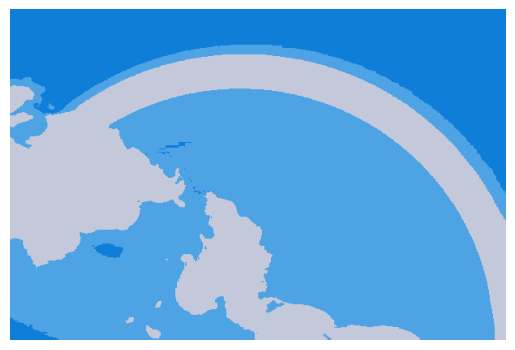

Ảnh sau khi test với k = 3


In [56]:
#Đưa ảnh trở về dạng 2D khi mà ta đã áp dụng thuật toán K-means và sau đó biểu diễn ảnh cũng như lưu ảnh trường hợp k = 3
img = generate_2d_img(img.shape, centroids, labels)
show_img(img)
save_img(img, "result_k3.png")
print("Ảnh sau khi test với k = 3")

In [57]:
#Sử dụng thuật toán K-means trường hợp k = 5
centroids, labels = kmeans(img_1d, k_clusters=5, max_iter=50, init_centroids='in_pixels')
print("Số cụm màu:", centroids.shape[0])

Số cụm màu: 5


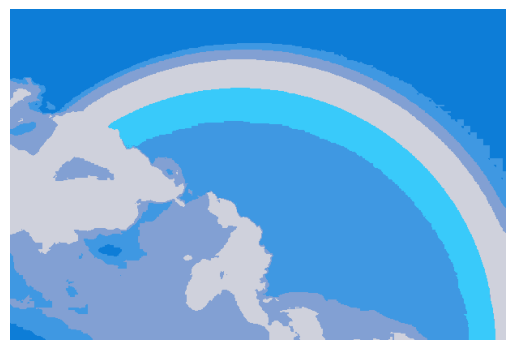

Ảnh sau khi test với k = 5


In [58]:
#Đưa ảnh trở về dạng 2D khi mà ta đã áp dụng thuật toán K-means và sau đó biểu diễn ảnh cũng như lưu ảnh trường hợp k = 5
img = generate_2d_img(img.shape, centroids, labels)
show_img(img)
save_img(img, "result_k5.png")
print("Ảnh sau khi test với k = 5")

In [59]:
#Sử dụng thuật toán K-means trường hợp k = 7
centroids, labels = kmeans(img_1d, k_clusters=7, max_iter=50, init_centroids='in_pixels')
print("Số cụm màu:", centroids.shape[0])

Số cụm màu: 7


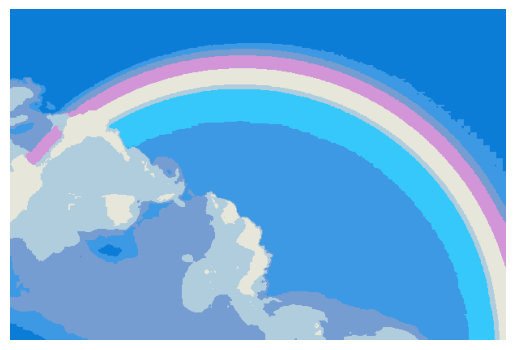

Ảnh sau khi test với k = 7


In [60]:
#Đưa ảnh trở về dạng 2D khi mà ta đã áp dụng thuật toán K-means và sau đó biểu diễn ảnh cũng như lưu ảnh trường hợp k = 7
img = generate_2d_img(img.shape, centroids, labels)
show_img(img)
save_img(img, "result_k7.png")
print("Ảnh sau khi test với k = 7")

## Main FUNCTION

In [61]:
# YOUR CODE HERE
# YOUR CODE HERE
def main():
    """
    Nén ảnh bằng K-Means cho ba giá trị K cố định (3, 5, 7).
    Sau khi nhập đường dẫn ảnh, chương trình:
        1. Hiển thị ảnh gốc và lưu <stem>_orig.{png,pdf}
        2. Nén ảnh với K = 3, 5, 7
        3. Với mỗi K: lưu <stem>_kK.{png,pdf} và hiển thị kết quả
    """
    in_path = input("Nhập đường dẫn / tên file ảnh: ").strip()
    if not in_path:
        print("Bạn chưa nhập đường dẫn!")
        return

    # Đọc & hiển thị ảnh gốc
    orig = read_img(in_path)
    stem = in_path.rsplit(".", 1)[0]           # tách đuôi file
    show_img(orig, "Ảnh gốc")
    save_img(orig, f"{stem}_orig.png")
    save_img(orig, f"{stem}_orig.pdf")
    # Danh sách K cần chạy
    k_list   = [3, 5, 7]
    max_iter = 50
    for k in k_list:
        _, comp, _, _ = compress_image(in_path, k, max_iter=max_iter)
        # Lưu PNG & PDF
        out_png = f"{stem}_k{k}.png"
        out_pdf = f"{stem}_k{k}.pdf"
        save_img(comp, out_png)
        save_img(comp, out_pdf)
        show_img(comp, f"Compressed (K={k})")


Nhập đường dẫn / tên file ảnh: /content/sample_data/dummy.jpg


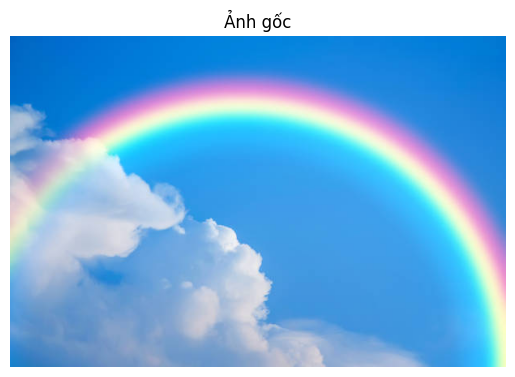

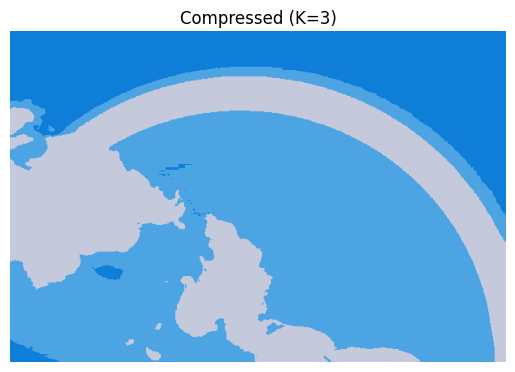

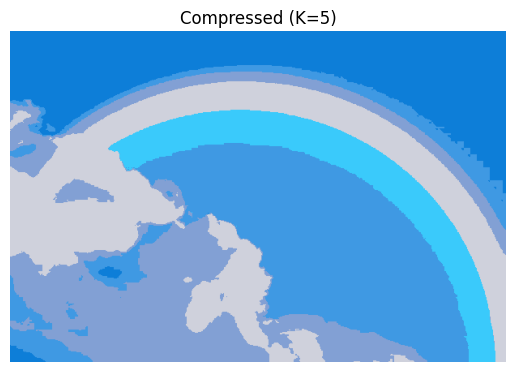

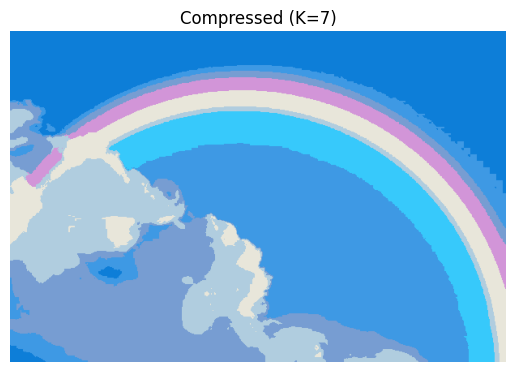

In [62]:
# Call main function
main()